# Zipline Algorithm

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports & Settings
Import pyfolio and zipline, and ingest the pricing data for backtesting.

You may have to install [Zipline](https://zipline.ml4trading.io/) first; you can do so using either:

```
pip install zipline-reloaded

pip install python-dotenv
```


In [3]:
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv()

True

In [1]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

import zipline
%load_ext zipline

## Ingest Zipline Bundle

In [6]:
!zipline ingest

[2024-11-29T22:54:11+0800-INFO][zipline.data.bundles.core]
 Ingesting quandl
[2024-11-29T22:54:11+0800-INFO][zipline.data.bundles.quandl]
[2024-11-29T22:54:56+0800-INFO][zipline.data.bundles.quandl]
 Parsing raw data.
[2024-11-29T22:55:07+0800-INFO][zipline.data.bundles.quandl]
 Generating asset metadata.
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/zipline/data/bundles/quandl.py:107: FutureWarning: The provided callable <function min at 0x103313490> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/PyfolioExample/.venv/lib/python3.10/site-packages/zipline/data/bundles/quandl.py:107: FutureWarning: The provided callable <fun

## Run Zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [7]:
%%zipline --start 2004-1-1 --end 2010-1-1 -o results.pickle --no-benchmark

# Zipline trading algorithm
# Taken from zipline.examples.olmar

import numpy as np
from zipline.finance import commission, slippage

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']

# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf

def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m)/algo.m
    algo.eps = eps
    algo.window_length = window_length
    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))

def handle_data(algo, data):
    m = algo.m
    
    x_tilde = np.zeros(m)
    b = np.zeros(m)
    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm
    
def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])
        
def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

period_open              period_close  \
2004-01-02 21:00:00+00:00 2004-01-02 14:31:00+00:00 2004-01-02 21:00:00+00:00   
2004-01-05 21:00:00+00:00 2004-01-05 14:31:00+00:00 2004-01-05 21:00:00+00:00   
2004-01-06 21:00:00+00:00 2004-01-06 14:31:00+00:00 2004-01-06 21:00:00+00:00   
2004-01-07 21:00:00+00:00 2004-01-07 14:31:00+00:00 2004-01-07 21:00:00+00:00   
2004-01-08 21:00:00+00:00 2004-01-08 14:31:00+00:00 2004-01-08 21:00:00+00:00   
...                                             ...                       ...   
2009-12-24 18:00:00+00:00 2009-12-24 14:31:00+00:00 2009-12-24 18:00:00+00:00   
2009-12-28 21:00:00+00:00 2009-12-28 14:31:00+00:00 2009-12-28 21:00:00+00:00   
2009-12-29 21:00:00+00:00 2009-12-29 14:31:00+00:00 2009-12-29 21:00:00+00:00   
2009-12-30 21:00:00+00:00 2009-12-30 14:31:00+00:00 2009-12-30 21:00:00+00:00   
2009-12-31 21:00:00+00:00 2009-12-31 14:31:00+00:00 2009-12-31 21:00:00+00:00   

                             long_value  shorts_count  longs_count  \
2004-01-02 21:00:00+00:00  0.000000e+00             0            0   
2004-01-05 21:00:00+00:00  1.012617e+07             0            7   
2004-01-06 21:00:00+00:00  1.009515e+07             0            7   
2004-01-07 21:00:00+00:00  1.011742e+07             0            6   
2004-01-08 21:00:00+00:00  9.859335e+06             0            4   
...                                 ...           ...          ...   
2009-12-24 18:00:00+00:00  1.611030e+07             0            4   
2009-12-28 21:00:00+00:00  1.627676e+07             0            4   
2009-12-29 21:00:00+00:00  1.640494e+07             0            3   
2009-12-30 21:00:00+00:00  1.659453e+07             0            5   
2009-12-31 21:00:00+00:00  1.621234e+07             0            5   

                           portfolio_value   ending_cash  starting_cash  \
2004-01-02 21:00:00+00:00     1.000000e+07  1.000000e+07   1.000000e+07   
2004-01-05 21:00:00+00:00     1.000000e+07 -1.261747e+05   1.000000e+07   
2004-01-06 21:00:00+00:00     1.007876e+07 -1.639664e+04  -1.261747e+05   
2004-01-07 21:00:00+00:00     1.013911e+07  2.168894e+04  -1.639664e+04   
2004-01-08 21:00:00+00:00     9.897065e+06  3.773005e+04   2.168894e+04   
...                                    ...           ...            ...   
2009-12-24 18:00:00+00:00     1.613946e+07  2.915782e+04   1.503458e+04   
2009-12-28 21:00:00+00:00     1.627136e+07 -5.396543e+03   2.915782e+04   
2009-12-29 21:00:00+00:00     1.639258e+07 -1.236016e+04  -5.396543e+03   
2009-12-30 21:00:00+00:00     1.643268e+07 -1.618491e+05  -1.236016e+04   
2009-12-31 21:00:00+00:00     1.612042e+07 -9.192017e+04  -1.618491e+05   

                           ending_value  starting_value  ...  max_leverage  \
2004-01-02 21:00:00+00:00  0.000000e+00    0.000000e+00  ...      0.000000   
2004-01-05 21:00:00+00:00  1.012617e+07    0.000000e+00  ...      1.012617   
2004-01-06 21:00:00+00:00  1.009515e+07    1.012617e+07  ...      1.012617   
2004-01-07 21:00:00+00:00  1.011742e+07    1.009515e+07  ...      1.012617   
2004-01-08 21:00:00+00:00  9.859335e+06    1.011742e+07  ...      1.012617   
...                                 ...             ...  ...           ...   
2009-12-24 18:00:00+00:00  1.611030e+07    1.610874e+07  ...      1.028153   
2009-12-28 21:00:00+00:00  1.627676e+07    1.611030e+07  ...      1.028153   
2009-12-29 21:00:00+00:00  1.640494e+07    1.627676e+07  ...      1.028153   
2009-12-30 21:00:00+00:00  1.659453e+07    1.640494e+07  ...      1.028153   
2009-12-31 21:00:00+00:00  1.621234e+07    1.659453e+07  ...      1.028153   

                           max_drawdown   sortino     sharpe alpha  beta  \
2004-01-02 21:00:00+00:00      0.000000       NaN        NaN  None  None   
2004-01-05 21:00:00+00:00      0.000000       NaN        NaN  None  None   
2004-01-06 21:00:00+00:00      0.000000       NaN   9.165151  None  None   
2004-01-07 21:00:00+00:00      0.000000       NaN  13.499945  None  None   
2004-01-

## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [8]:
import pandas as pd

results = pd.read_pickle('results.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [9]:
returns

2004-01-02 00:00:00+00:00    0.000000
2004-01-05 00:00:00+00:00    0.000000
2004-01-06 00:00:00+00:00    0.007876
2004-01-07 00:00:00+00:00    0.005989
2004-01-08 00:00:00+00:00   -0.023873
                               ...   
2009-12-24 00:00:00+00:00    0.000973
2009-12-28 00:00:00+00:00    0.008173
2009-12-29 00:00:00+00:00    0.007450
2009-12-30 00:00:00+00:00    0.002446
2009-12-31 00:00:00+00:00   -0.019002
Name: returns, Length: 1511, dtype: float64

## Single plot example
Make one plot of the top 5 drawdown periods.

Text(0.5, 0, 'Date')

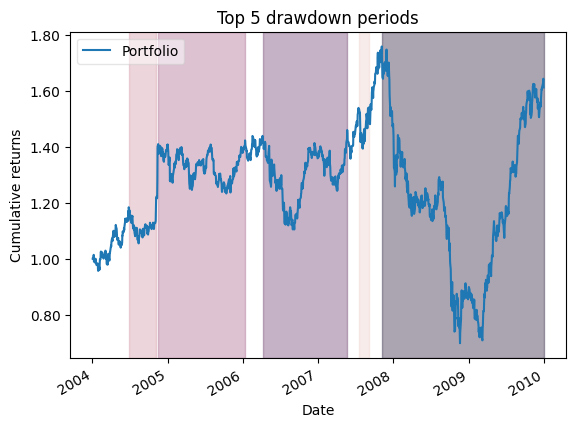

In [10]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

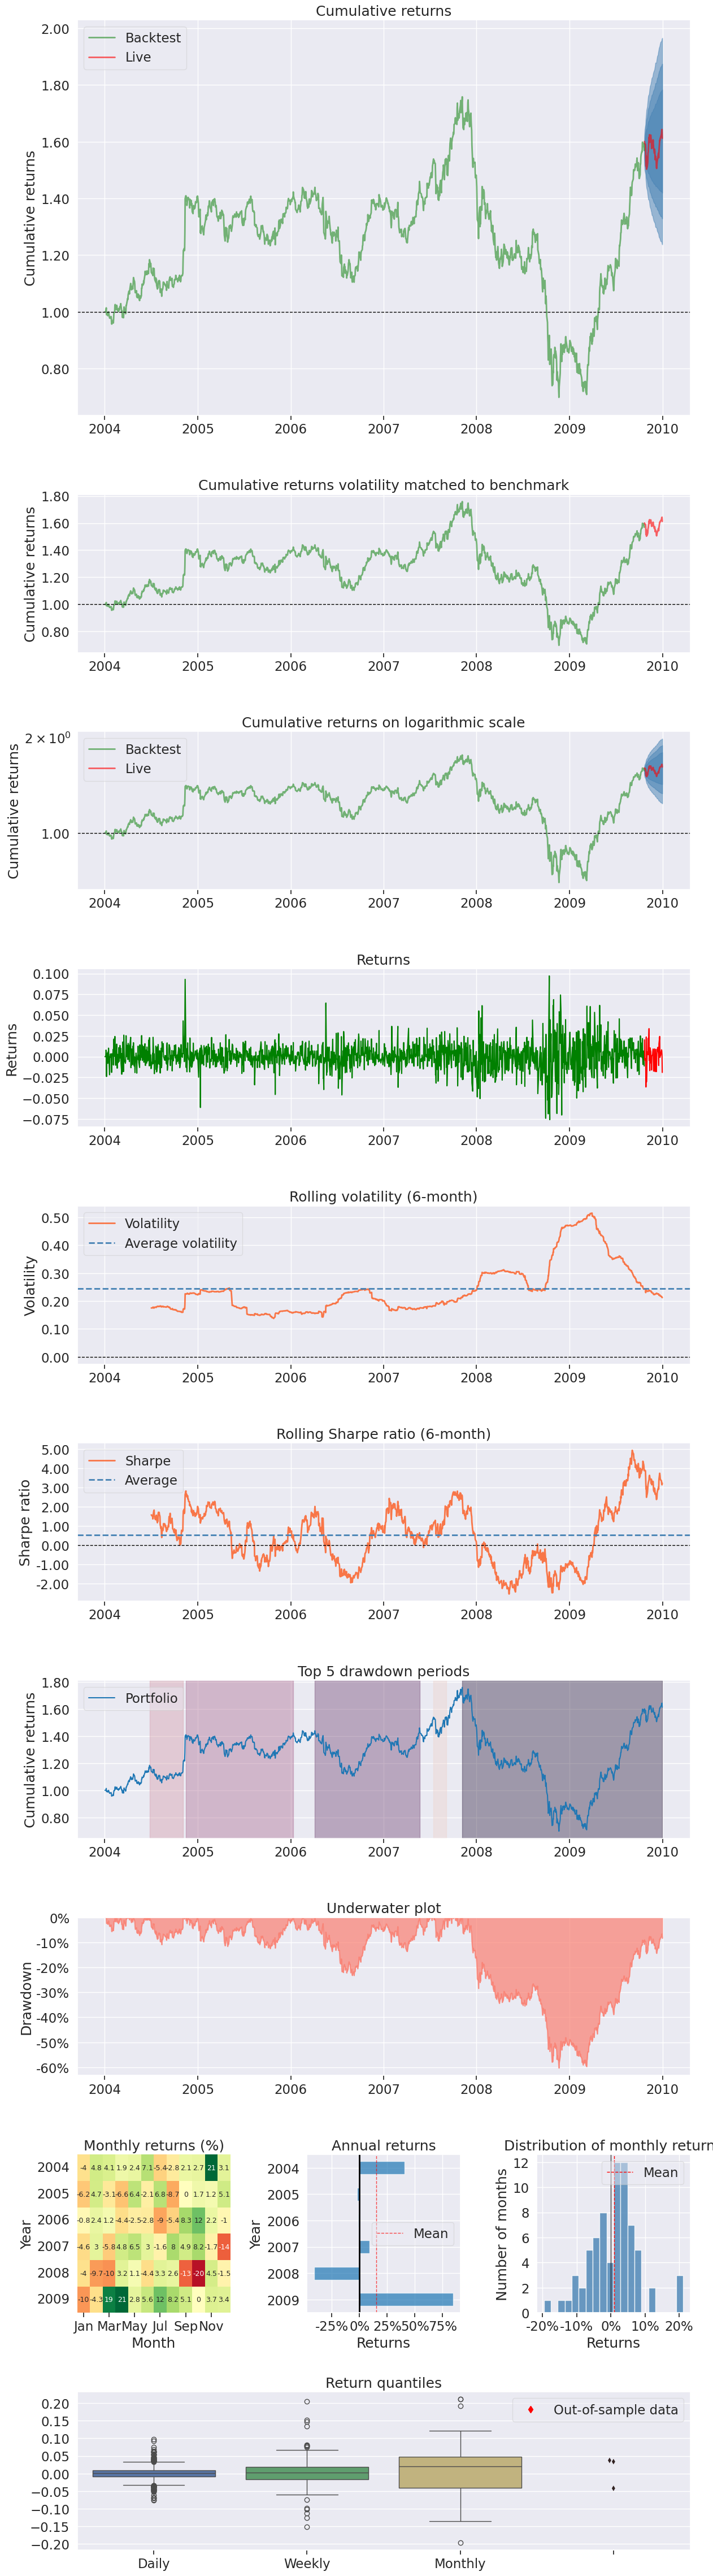

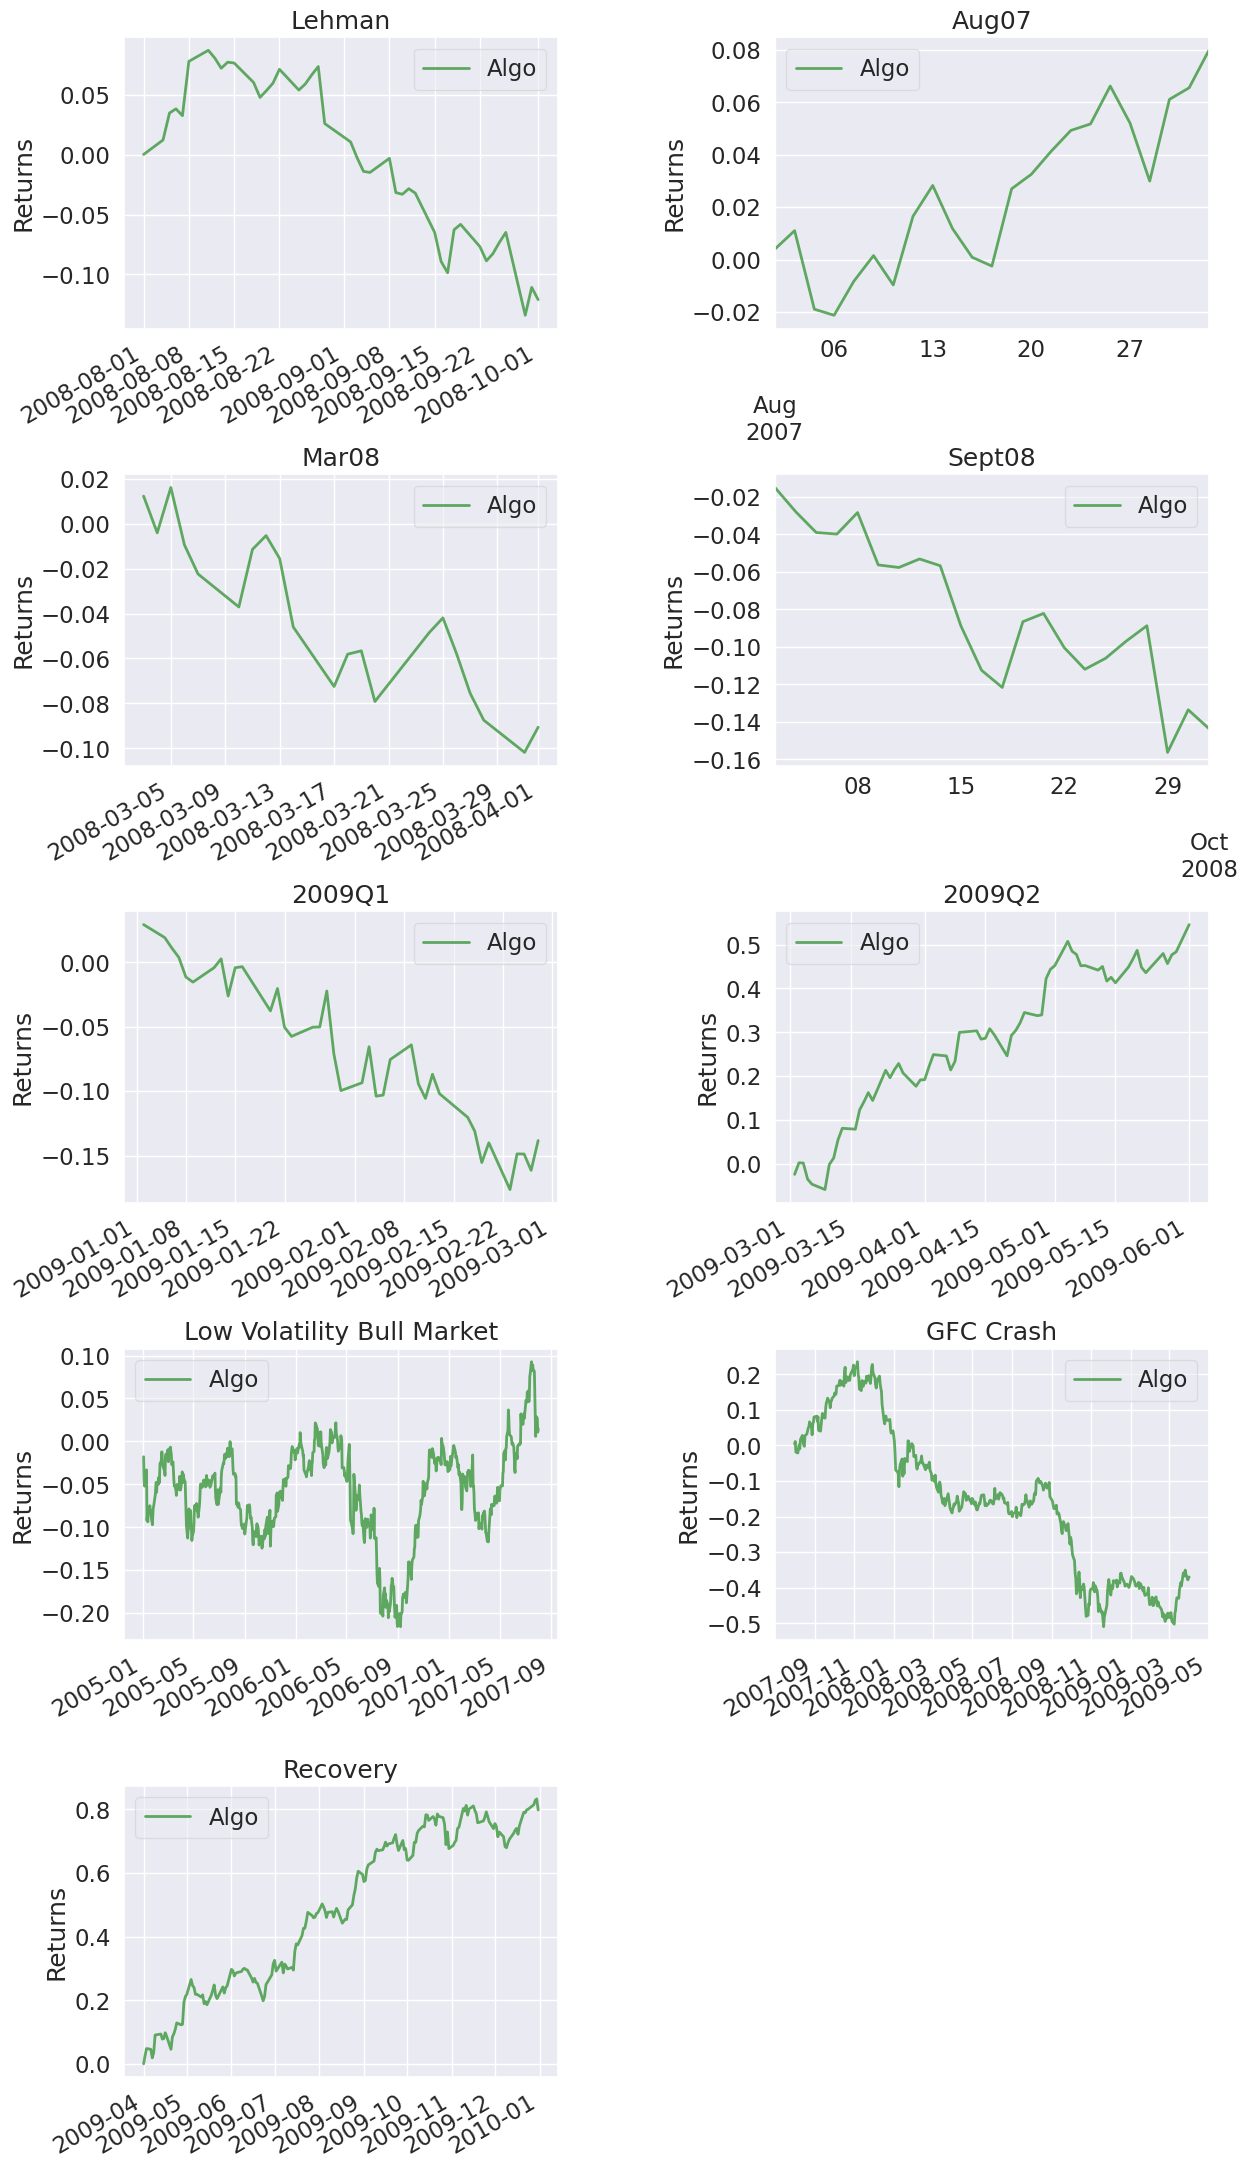

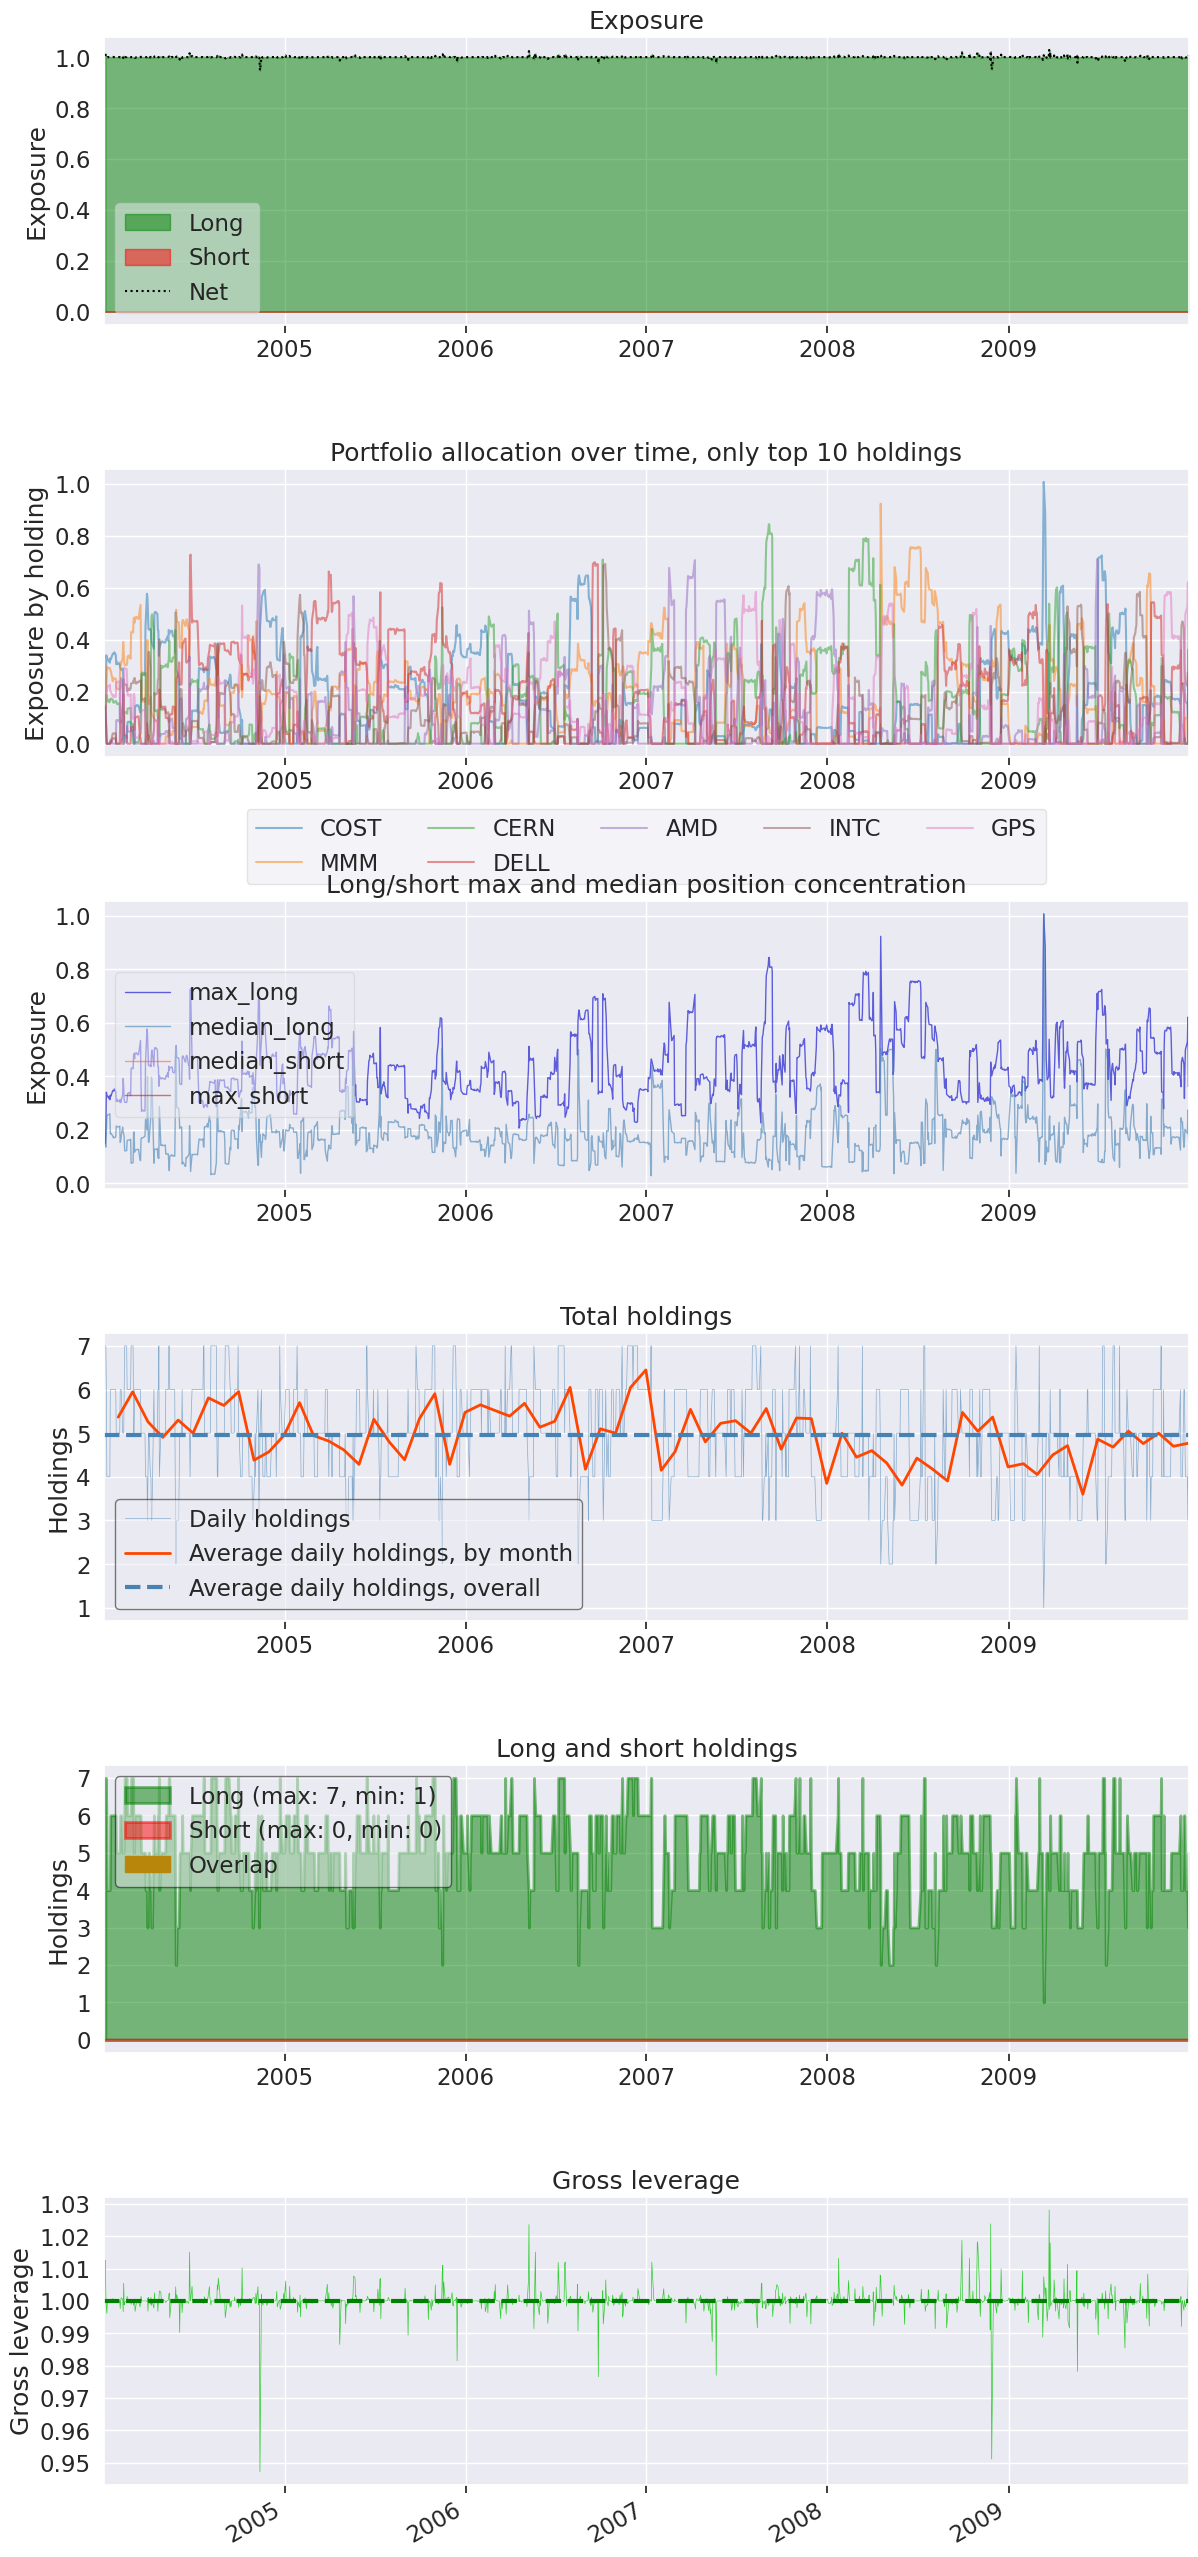

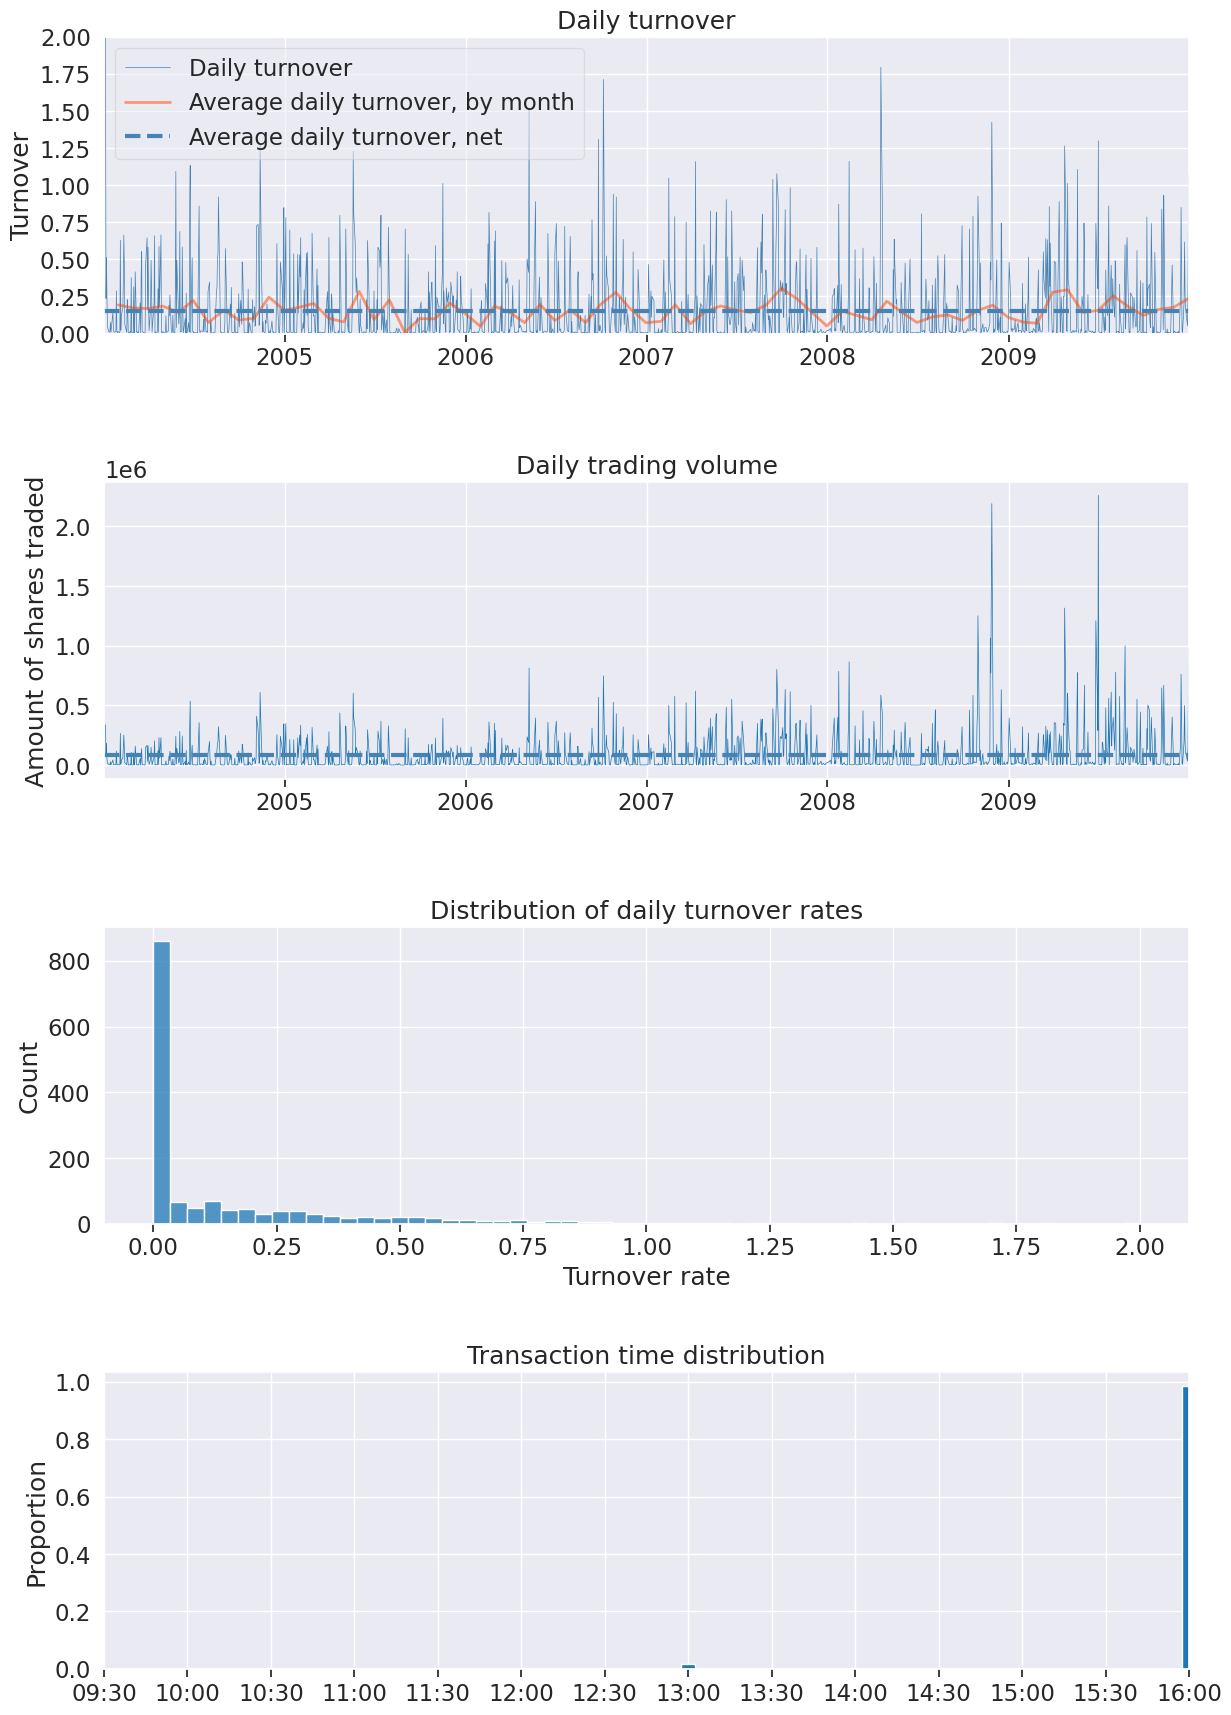

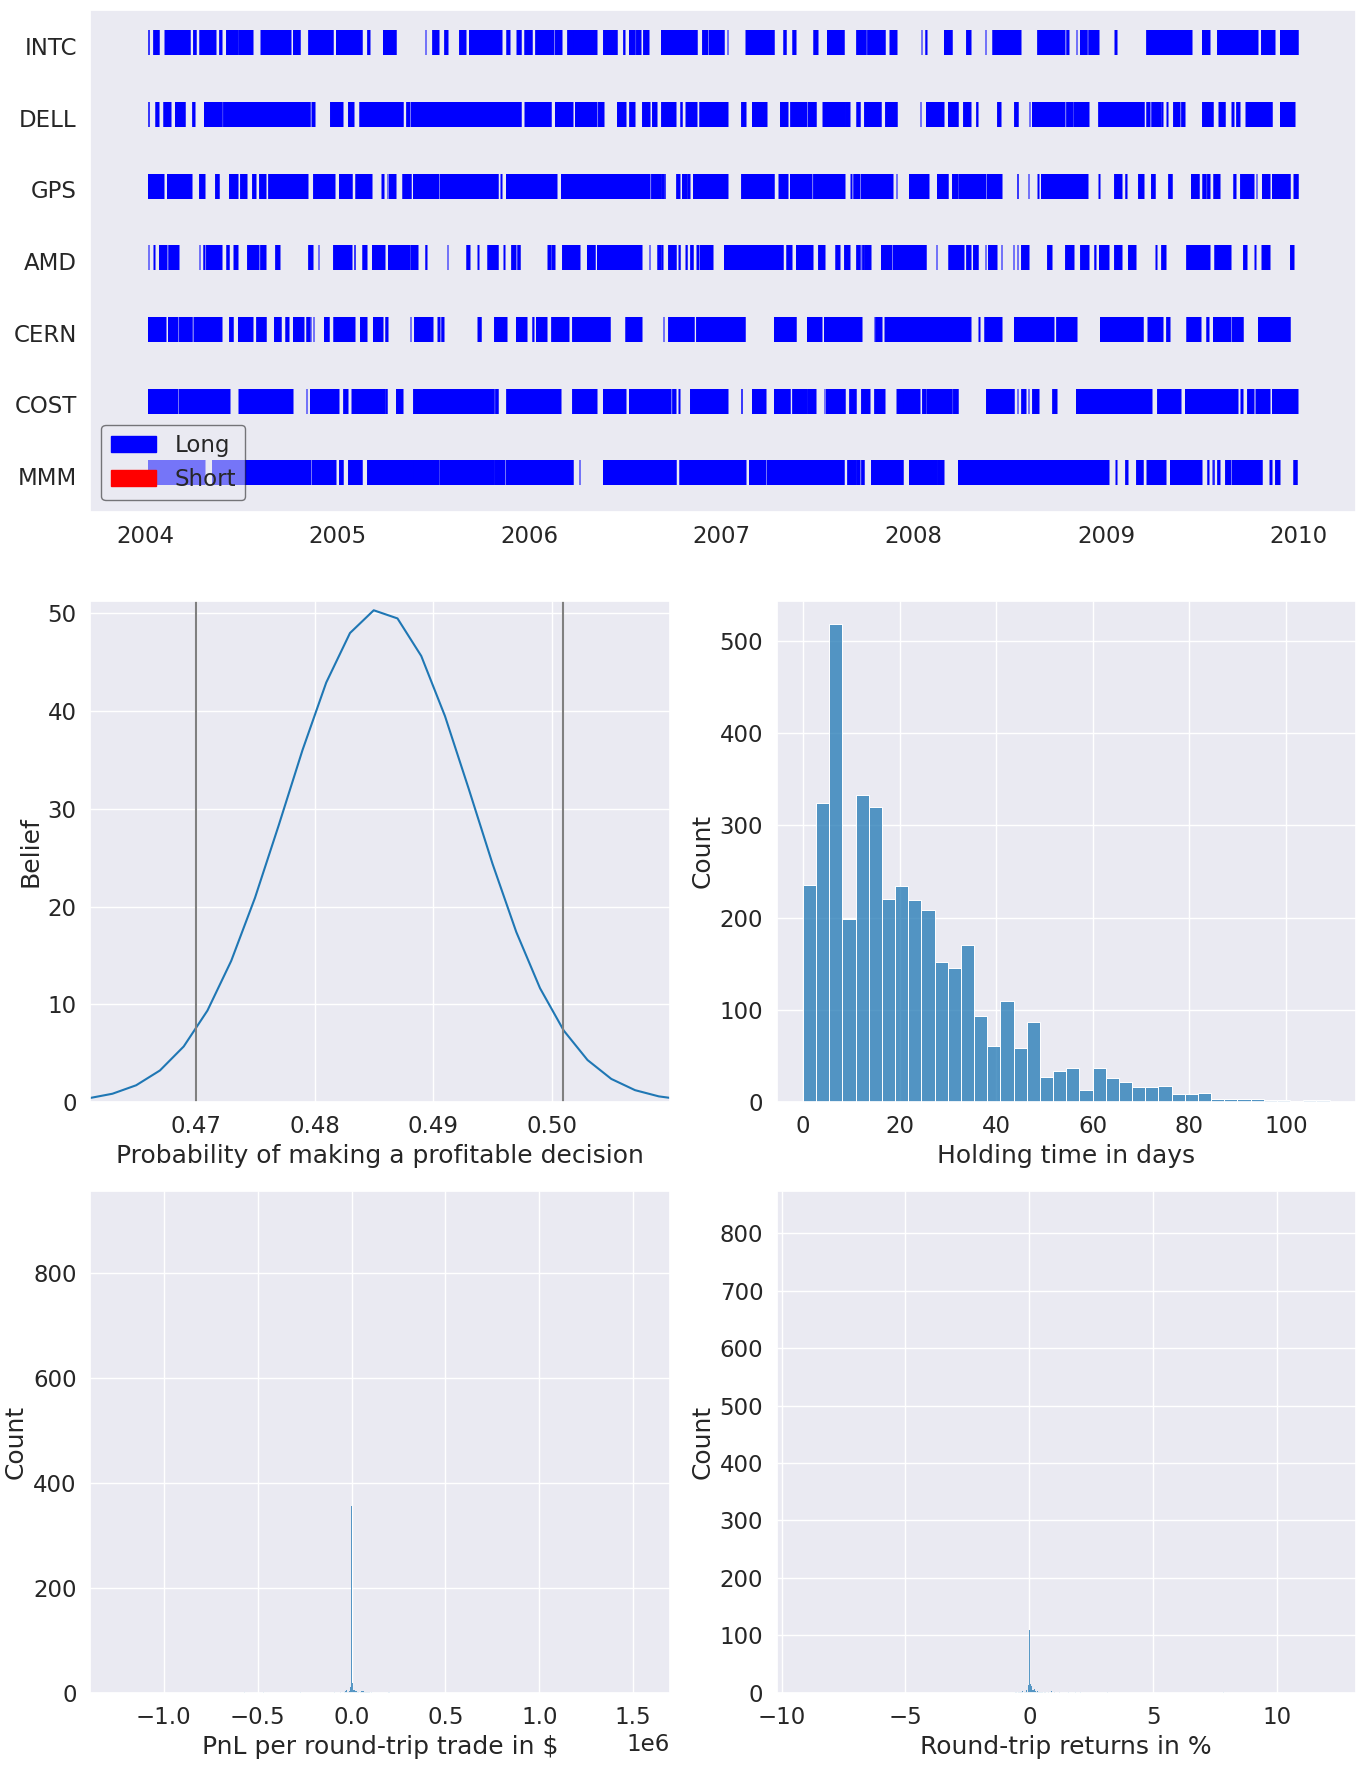

In [11]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

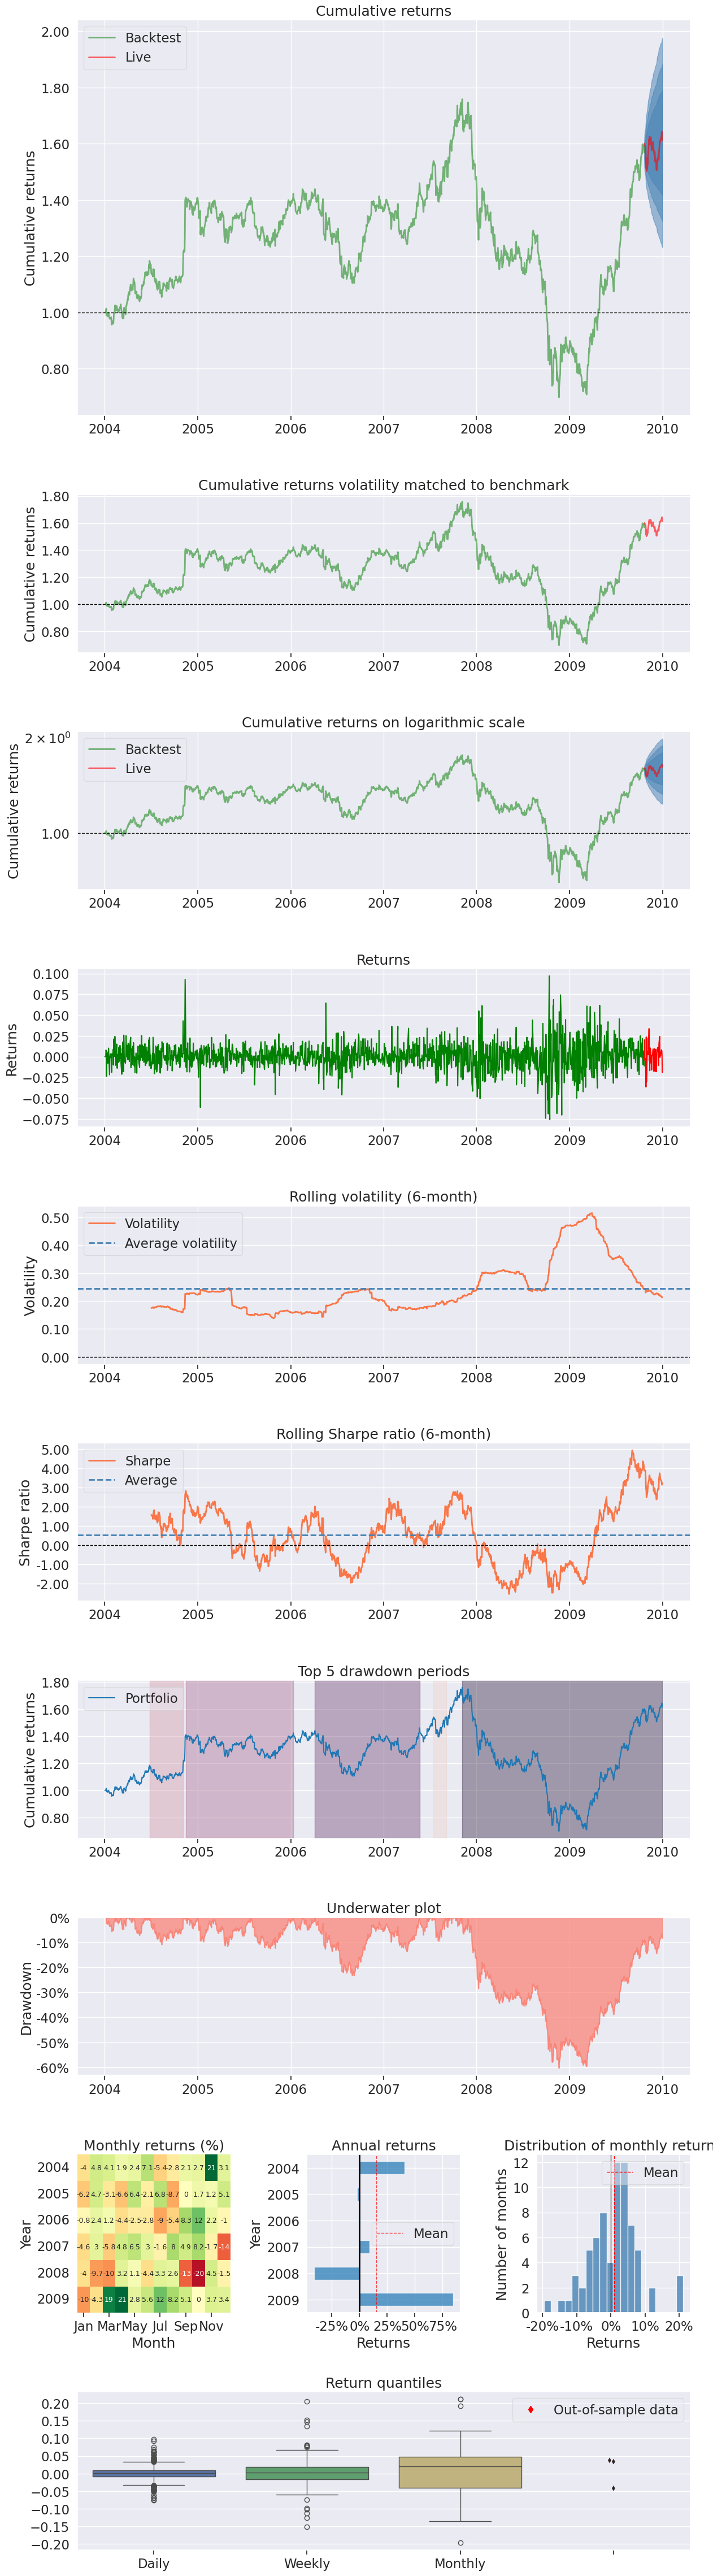

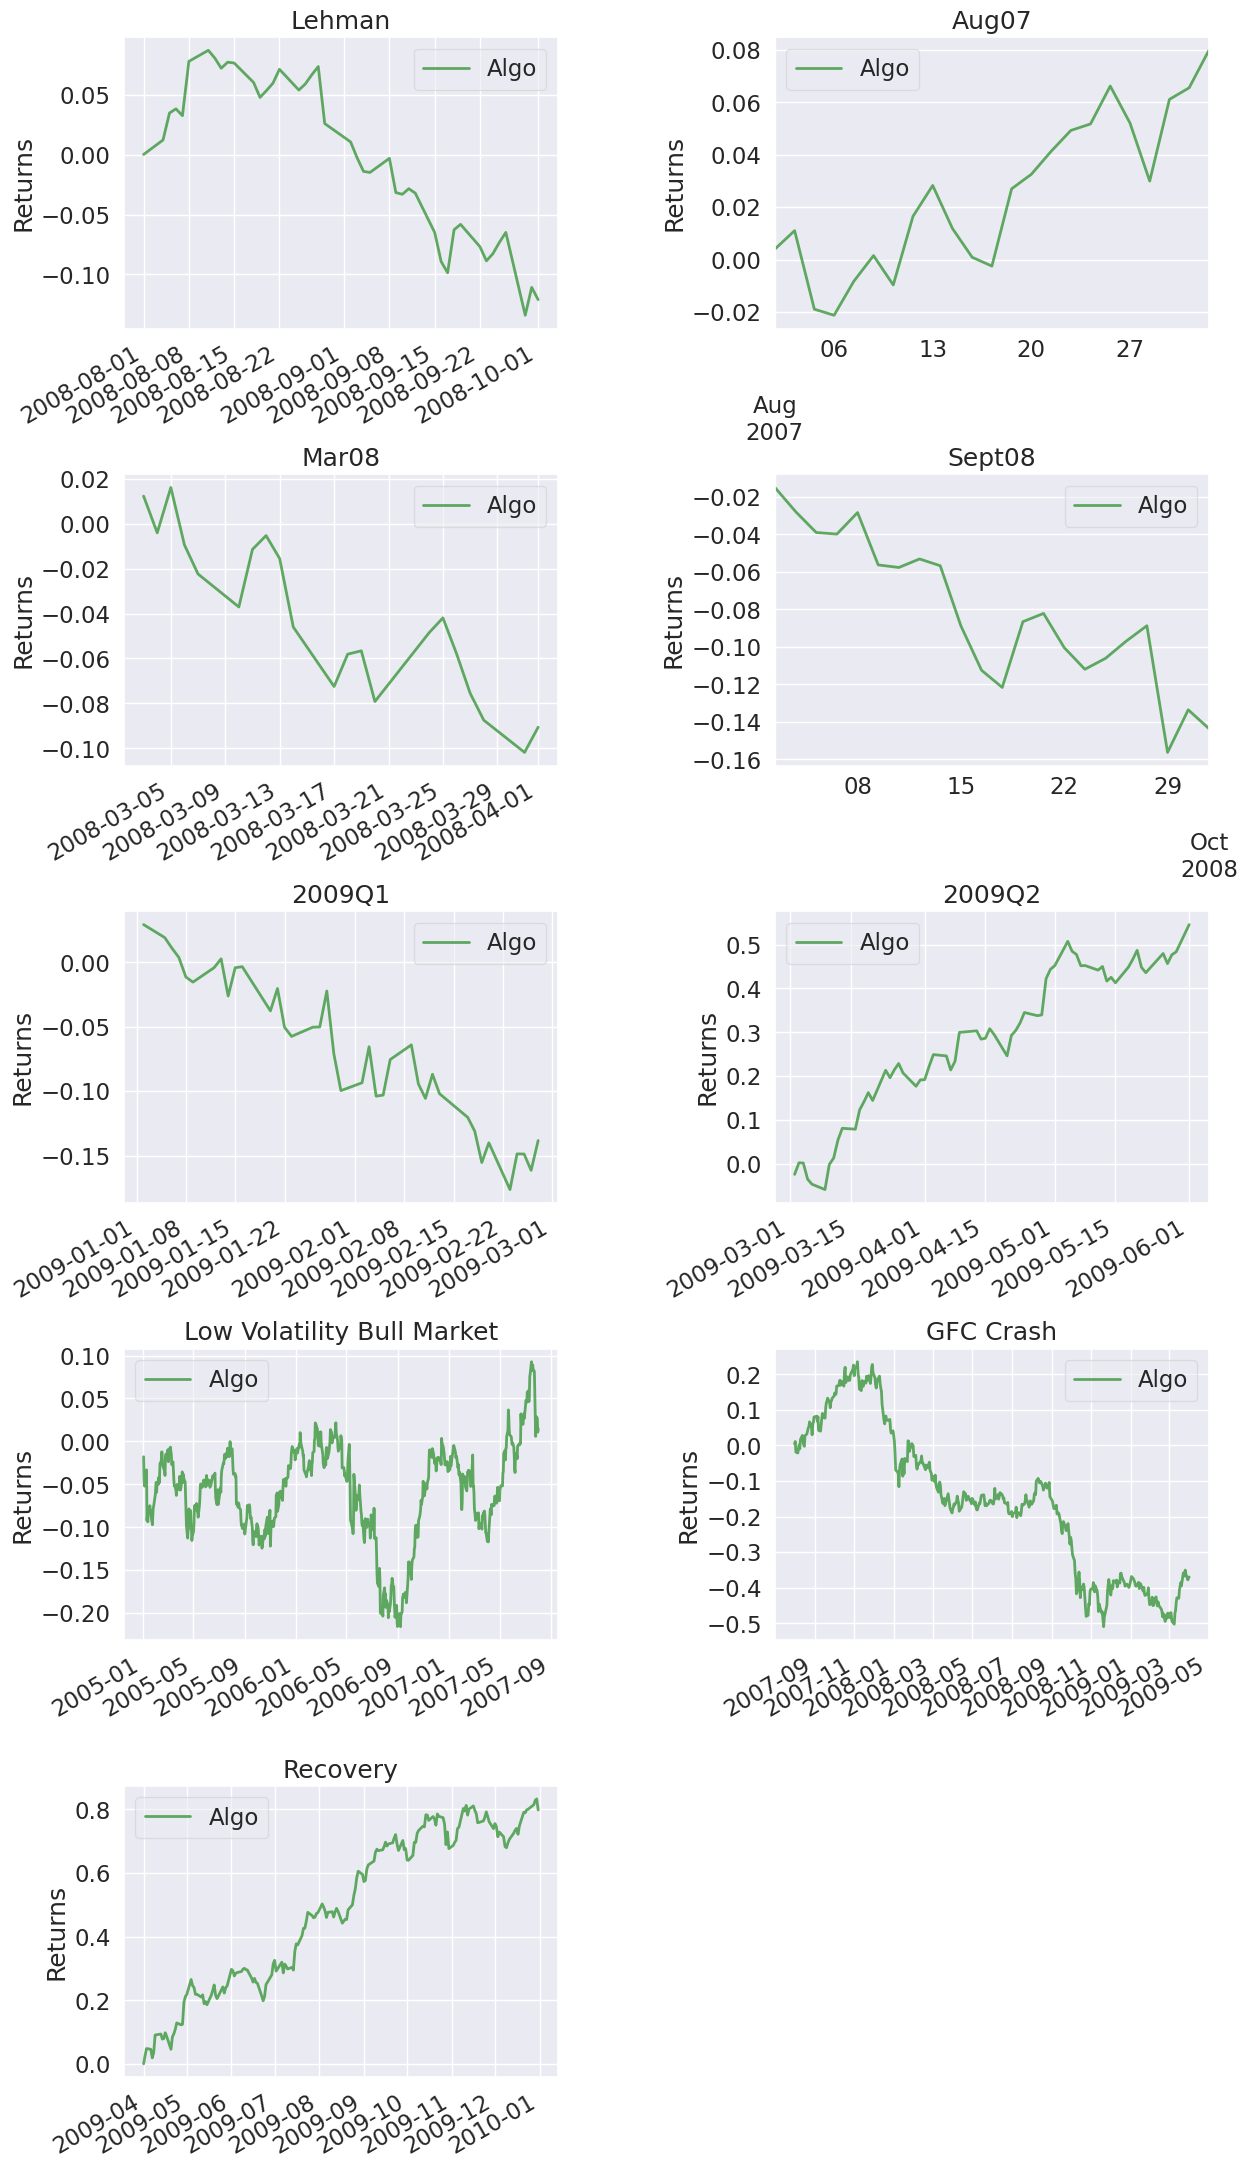

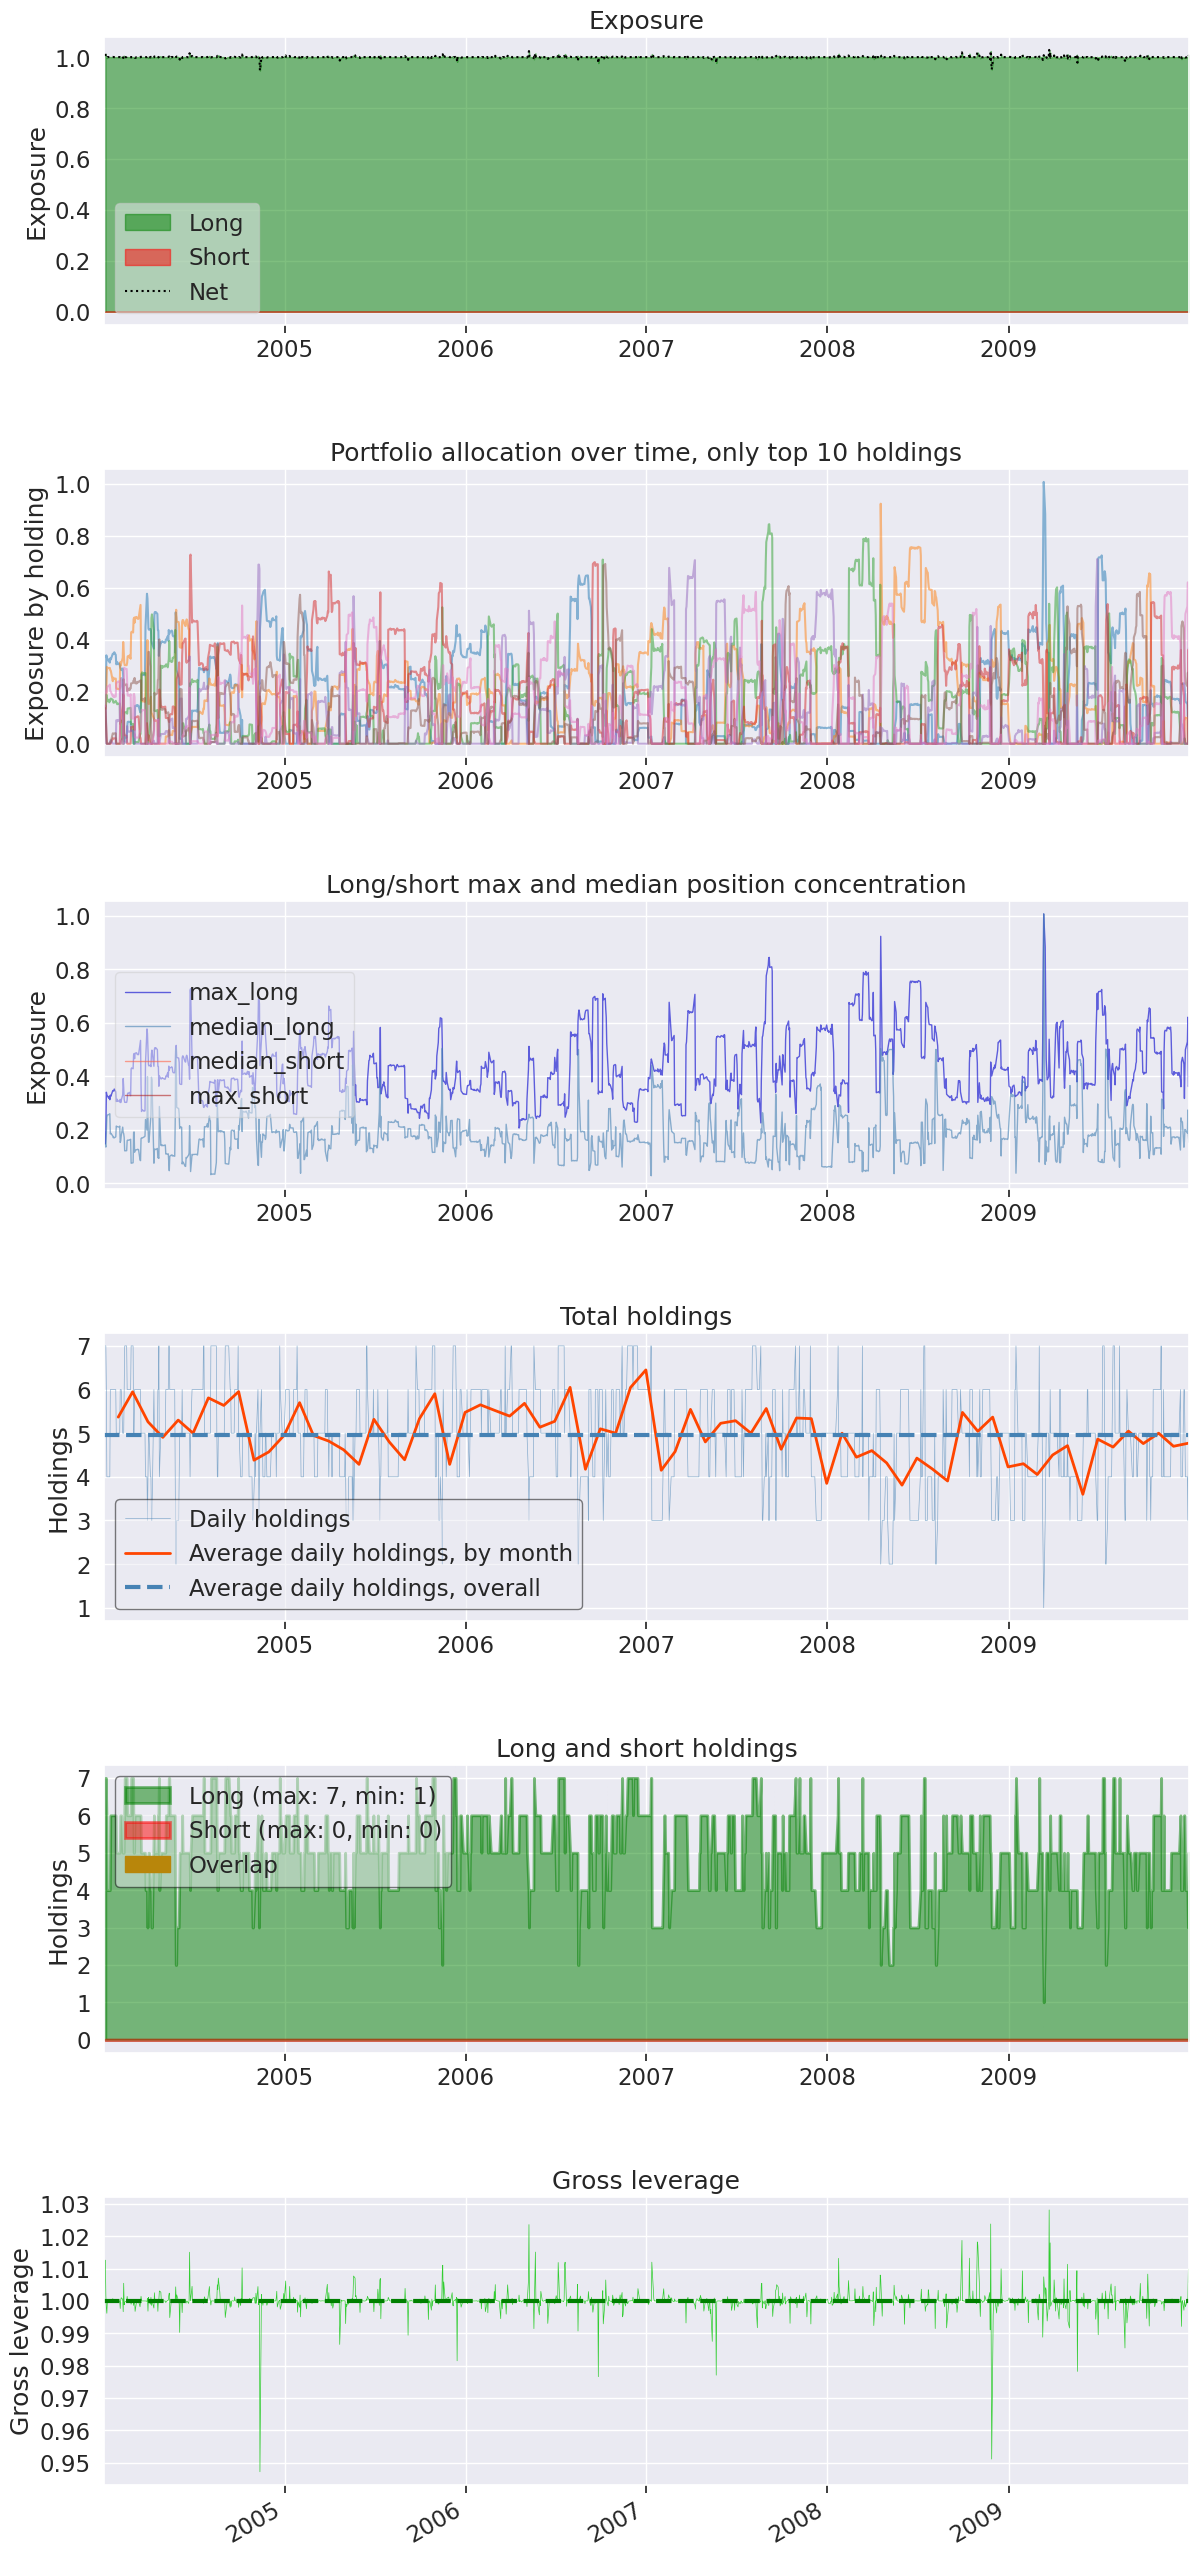

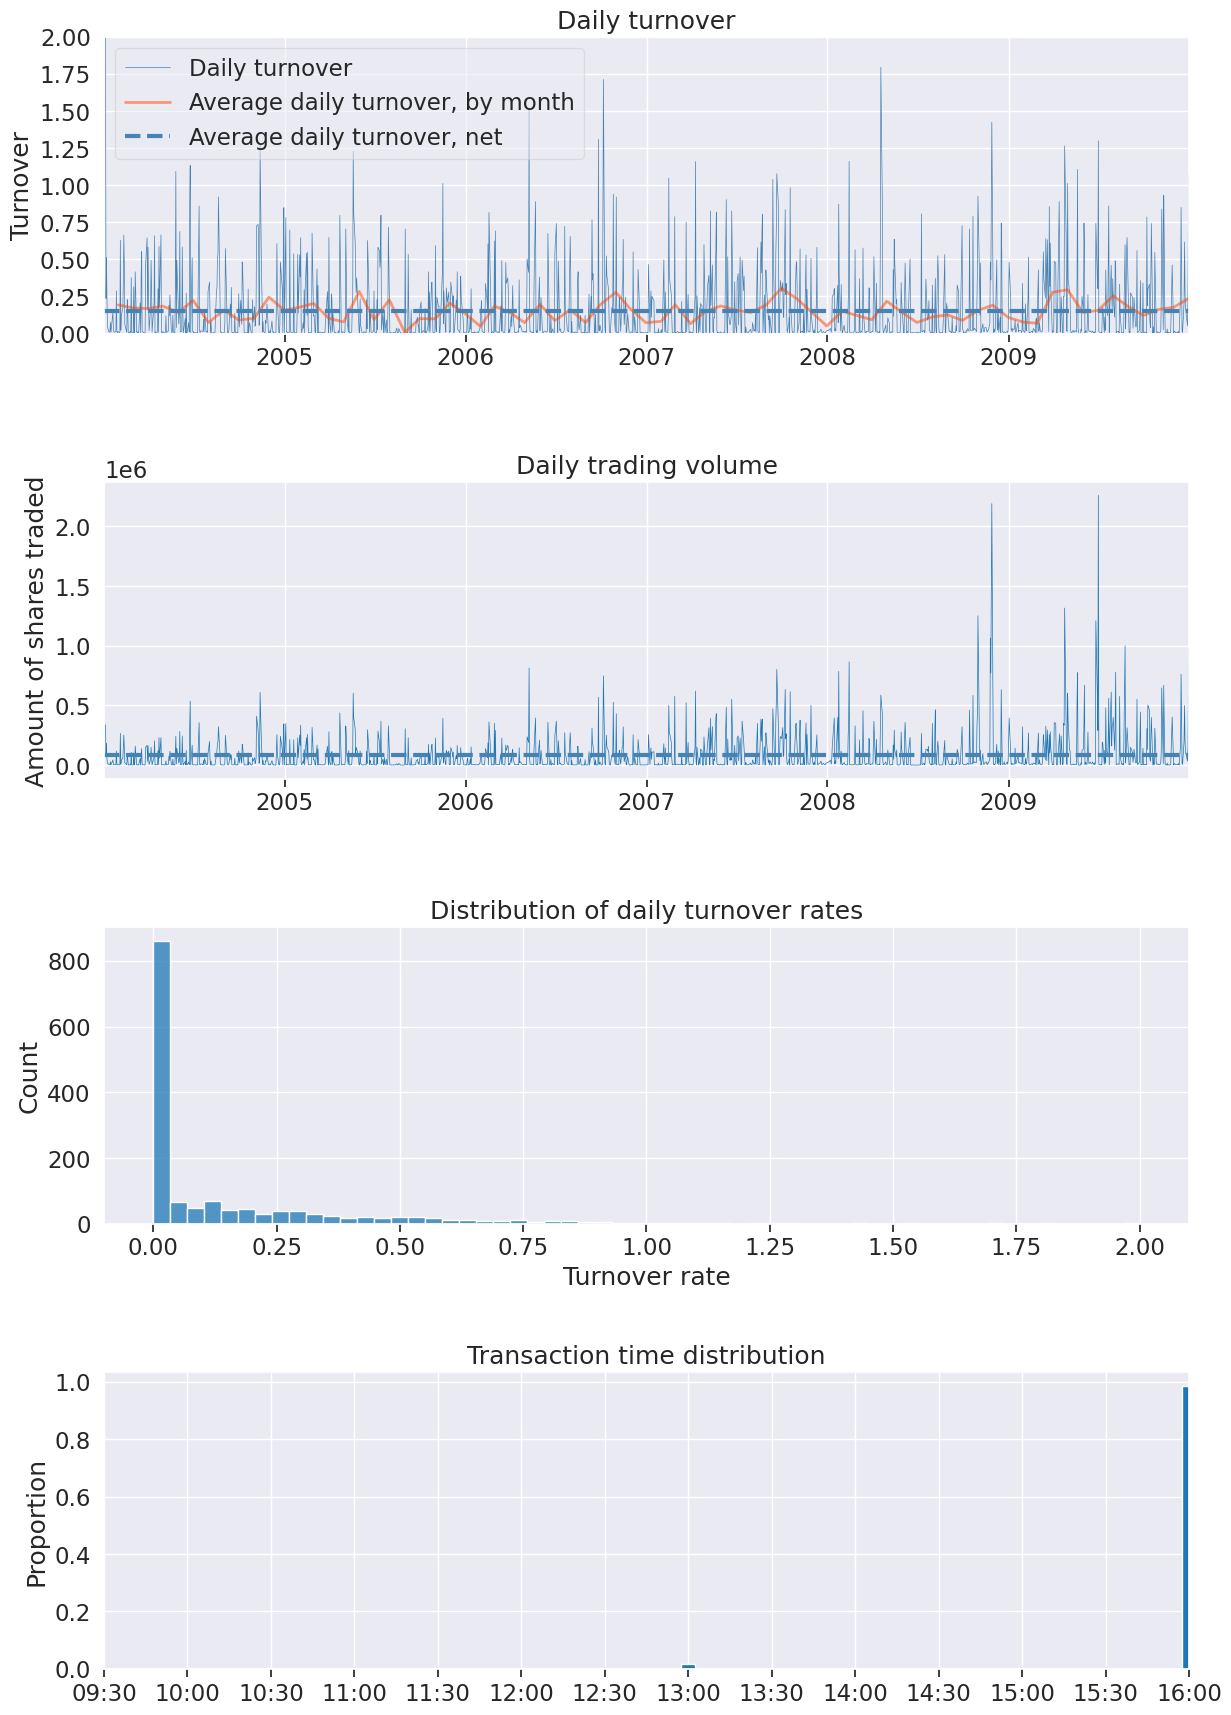

In [12]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', hide_positions=True)